In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [8]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [9]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [10]:
X_train_cls = load_cls(path+"X_train_cls.p")
X_val_cls = load_cls(path+"X_val_cls.p")

In [11]:
print(len(X_train_cls))

75000


In [12]:
y_train = load_cls(path+"y_train.p")
y_val = load_cls(path+"y_val.p")

In [13]:
from sklearn import svm

In [14]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty': ['l1','l2'],
    #'dual' : [False, True],
#     'loss' : ['hinge','squared_hinge'],
     'C': [0.001, 0.01, 0.1, 1,10]
 }

In [15]:
gs_clf = GridSearchCV(svm.LinearSVC(verbose=4,max_iter=n_iter,dual=False), 
                      parameters, cv=5, iid=True, n_jobs=-1,verbose=4)

In [16]:
stime = time.time()
model = gs_clf.fit(X_train_cls, y_train)
print ("Training time:",time.time() - stime)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  50 | elapsed:  2.2min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:  5.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.1min finished


[LibLinear]Training time: 817.2615451812744


In [26]:
model.best_score_

0.6997066666666667

In [27]:
from sklearn.calibration import CalibratedClassifierCV
ccmodel = CalibratedClassifierCV(model, cv='prefit')
ccmodel.fit(X_val_cls, y_val)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=4),...     pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4),
            cv='prefit', method='sigmoid')

In [19]:
ccmodel.score(X_val_cls, y_val)

0.6457333333333334

In [20]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'C': 0.001, 'penalty': 'l2'}
C: 0.001
penalty: 'l2'


In [21]:
pickle.dump(model,open("SVM_Cls_SVCLinear_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [22]:
X_test_cls = load_cls(path+"X_test_cls.p")
y_test = load_cls(path+"y_test.p")

In [23]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [24]:
from sklearn.metrics import accuracy_score
import sklearn

In [25]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []


# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel =svm.LinearSVC(verbose=4,
                             max_iter=n_iter,
                             dual=False,
                             C=model.best_params_['C'],
                             penalty=model.best_params_['penalty'])

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    ccBestModel = CalibratedClassifierCV(bestModel, cv=2)
    ccBestModel.fit(X_train_cls[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    #print (X_train_cls.shape,y_train.shape,X_val_f.shape, y_val.shape)
    
    stime=time.time()
    preds_val = ccBestModel.predict(X_val_cls)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)    
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test = ccBestModel.predict(X_test_cls)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = ccBestModel.predict_proba(X_test_cls)
    #print (bestModel.decision_function(X_test_f))
    #input("WWW")
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)
print (preds_test_probs)

SampleSize: 100
[LibLinear][LibLinear]Train Time:0.02 sec
Validation Accuracy: 53.67%
Validation Time:0.04 sec
Test Accuracy: 54.07%
Test Time:0.03 sec
(0.49124444444444626, 0.25, 0.642)
MRR: 0.49124444444444626
MRR Time:0.71 sec
SampleSize: 500
[LibLinear][LibLinear]Train Time:0.05 sec
Validation Accuracy: 56.11%
Validation Time:0.03 sec
Test Accuracy: 55.54%
Test Time:0.03 sec
(0.49762380952381075, 0.25533333333333336, 0.644)
MRR: 0.49762380952381075
MRR Time:1.58 sec
SampleSize: 1000
[LibLinear][LibLinear]Train Time:0.10 sec
Validation Accuracy: 57.29%
Validation Time:0.03 sec
Test Accuracy: 57.82%
Test Time:0.03 sec
(0.5179000000000012, 0.27466666666666667, 0.686)
MRR: 0.5179000000000012
MRR Time:0.95 sec
SampleSize: 10000
[LibLinear][LibLinear]Train Time:2.08 sec
Validation Accuracy: 62.21%
Validation Time:0.03 sec
Test Accuracy: 62.89%
Test Time:0.05 sec
(0.5672555555555576, 0.33066666666666666, 0.762)
MRR: 0.5672555555555576
MRR Time:0.66 sec
SampleSize: 20000
[LibLinear][LibLin

In [28]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Cls_LinearSVC_Accuracy.png")
    #plt.show()

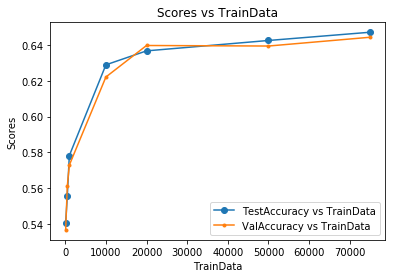

In [29]:
accuracyVisualization()

In [30]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Cls_LinearSVC_Mrr.png")
    plt.show()

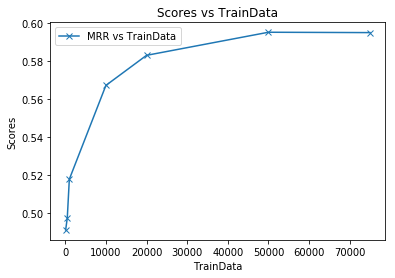

In [31]:
mrrVisualization()

In [32]:
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("SVM_Cls_LinearSVC_Precision.png")
    plt.show()

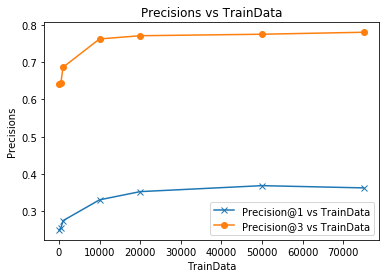

In [33]:
precisionVisualization()

In [41]:
bmodel =svm.LinearSVC(verbose=4,
                         max_iter=n_iter,
                         dual=False,
                         C=model.best_params_['C'],
                         penalty=model.best_params_['penalty'])

print("SampleSize:",eachTrain)

stime=time.time()
bmodel.fit(X_train_cls,y_train)   
print("Train Time:%.2f sec"%(time.time()-stime))

SampleSize: 75000
[LibLinear]Train Time:31.11 sec


In [50]:
bmodel.coef_.argsort()[0][-10:][::-1]

array([570, 766, 684, 528, 420, 358,   7, 365, 201, 425])

In [51]:
bmodel.coef_.argsort()[0][-15:][::-1]

array([570, 766, 684, 528, 420, 358,   7, 365, 201, 425, 760, 663, 179,
       224, 448])

In [52]:
pickle.dump(bmodel,open("SVM_Cls_SVCLinear_Best.pkl",'wb'))